# Cleaning the Open PV Data Set

- Load and check data
    - load data
    - check for null and missing values
    - Outlier detection

In [1]:
# Import Libararies
import pandas as pd
import numpy as np

## Load and check data

In [12]:
# Load Data
df = pd.read_csv("./openpv_all.csv")
df.head(3)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,5,8,12,13,14,15,16,20,23,25,26,27,28,32,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,state,date_installed,incentive_prog_names,type,size_kw,appraised,zipcode,install_type,installer,cost_per_watt,...,new_constr,effic_1,cust_county,tracking,inv_model_clean,mod_cost_real,inv_cost_real,bos_powerclerk_real,permitting_real,3rdparty
0,TX,12/12/2013,Austin Energy,uir,10.56,NaN,78702.0,residential,NaN,2.897777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TX,07/11/2014,Austin Energy,uir,12.72,NaN,78702.0,residential,NaN,3.144654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,01/17/2014,Austin Energy,uir,5.40,NaN,78702.0,residential,NaN,4.197330,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 81 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           797958 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean 

## Checking for non null values

In [14]:
# Check for Null values
df.isnull().sum()

state                                0
date_installed                       5
incentive_prog_names            222757
type                                 5
size_kw                              5
appraised                       796679
zipcode                              5
install_type                     42581
installer                       318068
cost_per_watt                   257582
cost                            257421
lbnl_tts_version_year           222757
lbnl_tts                        222757
city                            221567
utility_clean                   227995
tech_1                          439796
model1_clean                    439796
county                           22063
annual_PV_prod                  239746
annual_insolation               239746
rebate                          634017
sales_tax_cost                  665406
tilt1                           637350
tracking_type                   494657
azimuth1                        657434
manuf2_clean             

There are loads of non null data. The best decision is to get rid of them

In [15]:
df.shape

(1020715, 81)

In [16]:
# Getting rid of columns where there's no data

# first getting a list all the column names where there's no data.
non_null_cols = [col for col in df.columns if df[col].notnull().sum() != 0]

In [17]:
# limiting the dataframe to just non-null columns
df = df[non_null_cols]

In [18]:
df.isnull().sum()

state                                0
date_installed                       5
incentive_prog_names            222757
type                                 5
size_kw                              5
appraised                       796679
zipcode                              5
install_type                     42581
installer                       318068
cost_per_watt                   257582
cost                            257421
lbnl_tts_version_year           222757
lbnl_tts                        222757
city                            221567
utility_clean                   227995
tech_1                          439796
model1_clean                    439796
county                           22063
annual_PV_prod                  239746
annual_insolation               239746
rebate                          634017
sales_tax_cost                  665406
tilt1                           637350
tracking_type                   494657
azimuth1                        657434
manuf2_clean             

In [19]:
df.shape

(1020715, 39)

There were 42 columns with non null values

### Incentive Program Names
These are probably pretty important to determining cost, so let's see if we can find some trend to impute it.

In [20]:
# There are a bunch of these incentive programs, which almost definitely have an influence on people's
# eventual cost of solar.

df['incentive_prog_names'].value_counts()

California Public Utilities Commission (Non-CSI Net Metered Systems)          260940
California Public Utilities Commission (California Solar Initiative)          148988
New York State Energy Research and Development Authority                       44012
Arizona Public Service                                                         40647
Massachusetts Clean Energy Center                                              36810
New Jersey Board of Public Utilities (SREC Program)                            34168
California Energy Commission (Emerging Renewables Program)                     27952
Massachusetts Department of Energy Resources                                   24828
Los Angeles Department of Water & Power                                        19757
California Energy Commission (New Solar Homes Partnership)                     17286
Connecticut Clean Energy Finance and Investment Authority                      15746
Salt River Project                                               

### Let's look at average cost_per_watt for these different commisions: 

In [21]:
# import the libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

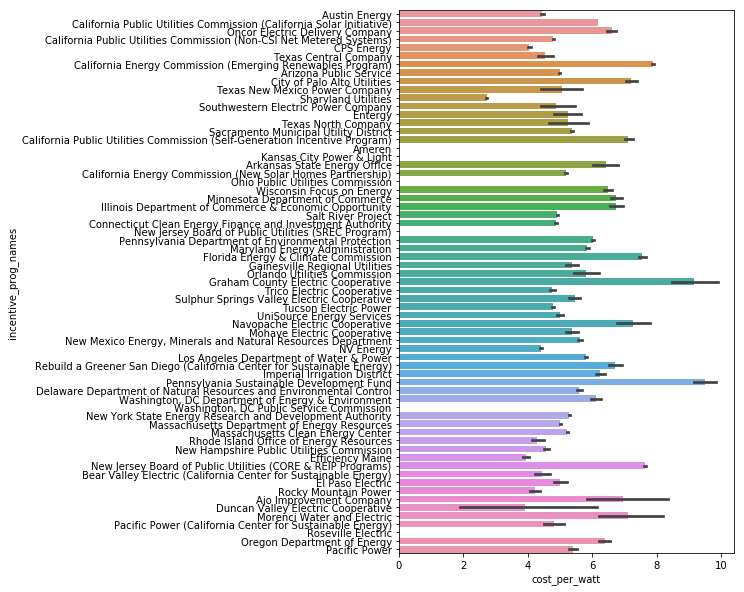

In [22]:
# There's definitely some variance around this, and it looks like within each of these the variance or price 
# is pretty tight.

fig = plt.figure(figsize=(6,10))

sns.barplot(x=df["cost_per_watt"], y=df["incentive_prog_names"], orient = 'h')

In [23]:
# Either values where the incentive is plank means they didn't have an incentive program, or that
# it isn't listed.  If it's the latter, maybe we can impute it.
null_incentive_state = df.loc[df['incentive_prog_names'].isnull(), :].groupby("state").size()

In [26]:
# looking at proportion by state with no incentive program compared to with incentive program may provide some clues 
zip(null_incentive_state.sort_values(ascending=False).index, 
    sorted(null_incentive_state/sum(null_incentive_state), reverse=True))

In [27]:
notnull_incentive_state = df.loc[df['incentive_prog_names'].notnull(), :].groupby("state").size()

zip(notnull_incentive_state.sort_values(ascending=False).index, 
    sorted(notnull_incentive_state/sum(notnull_incentive_state), reverse=True))

In [29]:
# looks like some states don't even show up, probably safe to assume that those states just don't have
# incentive programs.

# given that, it seems like it may be difficult to distingush between cases where there was no incentive program
# available and where it was unreported.

df['incentive_prog_names'].fillna("no_incentive_program", inplace=True)

### Utility_Clean
I have a hunch that this is going to be heavily linked to states and/or counties, we can probably impute this by grabbing the mode value from each state or county. Let's explore.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           1020715 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean

In [31]:
# We can already see that there's quite a bit of deviation within states, for instance a lot of CA is on 
# Los Angeles Department of Water & Power, and a lot is on Pacific Gas & Electric Co, maybe county will help.
df.groupby(['state', 'utility_clean']).size()

state  utility_clean                              
AR     Carroll Electric Coop Corp                         1
       Carroll Electric Coop Corp - (AR)                  1
       Entergy Arkansas Inc                              61
       Oklahoma Gas & Electric Co                         3
       Southwestern Electric Power Co                    32
AZ     Ajo Improvement Company                            3
       Arizona Public Service                         40647
       Duncan Valley Electric Cooperative                 5
       Graham County Electric Cooperative               129
       Mohave Electric Cooperative                      449
       Morenci Water and Electric                         3
       Navopache Electric Cooperative                   140
       Salt River Project                             15275
       Sulphur Springs Valley Electric Cooperative     1266
       Trico Electric Cooperative                      1357
       Tucson Electric Power                     

In [32]:
# this looks quite a bit better, looks like in most counties there's only one or maybe 2 utilities that
# people are on.
county_utilities = pd.DataFrame(df.groupby(['state', 'county', 'utility_clean']).size()).reset_index()
county_utilities

,state,county,utility_clean,0
0,AR,Benton,Southwestern Electric Power Co,6
1,AR,Boone,Entergy Arkansas Inc,3
2,AR,Carroll,Entergy Arkansas Inc,4
3,AR,Chicot,Entergy Arkansas Inc,1
4,AR,Crawford,Oklahoma Gas & Electric Co,2
5,AR,Faulkner,Entergy Arkansas Inc,3
6,AR,Franklin,Oklahoma Gas & Electric Co,1
7,AR,Garland,Entergy Arkansas Inc,4
8,AR,Grant,Entergy Arkansas Inc,2
9,AR,Hempstead,Entergy Arkansas Inc,1


In [33]:
# Looking at california, looks like this is pretty robust, I'm also noticing that there's a ton of double labled stuff
# let's also change 'Pacific Gas & Electric Co' to "Pacific Gas & Electric Company"

county_utilities[county_utilities['state'] == "CA"]

,state,county,utility_clean,0
71,CA,Alameda,Pacific Gas & Electric Co,191
72,CA,Alameda,Pacific Gas & Electric Company,16285
73,CA,Alameda,Port of Oakland,1
74,CA,Alameda,Southern California Edison,5
75,CA,Amador,Pacific Gas & Electric Co,1
76,CA,Amador,Pacific Gas & Electric Company,663
77,CA,Butte,Pacific Gas & Electric Co,76
78,CA,Butte,Pacific Gas & Electric Company,5383
79,CA,Butte,Southern California Edison,1
80,CA,Calaveras,Pacific Gas & Electric Company,1047


In [34]:
# changing some misnamed PG&E values

df.loc[df['utility_clean'] == "Pacific Gas & Electric Co", 'utility_clean'] = "Pacific Gas & Electric Company"

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020715 entries, 0 to 1020714
Data columns (total 39 columns):
state                          1020715 non-null object
date_installed                 1020710 non-null object
incentive_prog_names           1020715 non-null object
type                           1020710 non-null object
size_kw                        1020710 non-null float64
appraised                      224036 non-null object
zipcode                        1020710 non-null float64
install_type                   978134 non-null object
installer                      702647 non-null object
cost_per_watt                  763133 non-null float64
cost                           763294 non-null float64
lbnl_tts_version_year          797958 non-null float64
lbnl_tts                       797958 non-null object
city                           799148 non-null object
utility_clean                  792720 non-null object
tech_1                         580919 non-null object
model1_clean